In [8]:
import os, sys, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from imgaug import augmenters as iaa
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [9]:
INPUT_SHAPE = (299,299,3)
BATCH_SIZE = 10

In [3]:
pwd

'C:\\Users\\Mahrang'

In [10]:
path_to_train = 'train'
data = pd.read_csv('train.csv')

In [11]:
train_dataset_info = []
for name, labels in zip(data['Id'], data['Target'].str.split(' ')):
    train_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':np.array([int(label) for label in labels])})
train_dataset_info = np.array(train_dataset_info)

In [13]:
from sklearn.model_selection import train_test_split
train_ids, test_ids, train_targets, test_target = train_test_split(
    data['Id'], data['Target'], test_size=0.2, random_state=42)

In [14]:
class data_generator:
    
    def create_train(dataset_info, batch_size, shape, augument=True):
        assert shape[2] == 3
        while True:
            random_indexes = np.random.choice(len(dataset_info), batch_size)
            batch_images = np.empty((batch_size, shape[0], shape[1], shape[2]))
            batch_labels = np.zeros((batch_size, 28))
            for i, idx in enumerate(random_indexes):
                image = data_generator.load_image(
                    dataset_info[idx]['path'], shape)   
                if augument:
                    image = data_generator.augment(image)
                batch_images[i] = image
                batch_labels[i][dataset_info[idx]['labels']] = 1
            yield batch_images, batch_labels
            
    
    def load_image(path, shape):        
        R = np.array(Image.open(path+'_red.png'))
        G = np.array(Image.open(path+'_green.png'))
        B = np.array(Image.open(path+'_blue.png'))
        Y = np.array(Image.open(path+'_yellow.png'))

        image = np.stack((
            R/2 + Y/2, 
            G/2 + Y/2, 
            B),-1)
        
        image = cv2.resize(image, (shape[0], shape[1]))
        image = np.divide(image, 255)
        return image  
                
            
    def augment(image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order=True)
        
        image_aug = augment_img.augment_image(image)
        return image_aug

In [15]:
train_datagen = data_generator.create_train(
    train_dataset_info, 5, (299,299,3), augument=True)

min: 0.0, max: 1.0


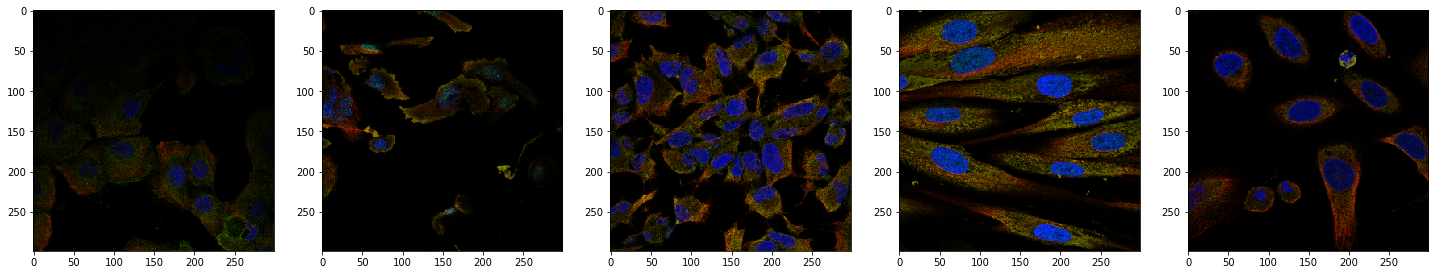

In [16]:
images, labels = next(train_datagen)

fig, ax = plt.subplots(1,5,figsize=(25,5))
for i in range(5):
    ax[i].imshow(images[i])
print('min: {0}, max: {1}'.format(images.min(), images.max()))

In [20]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.models import Model
from keras.applications import InceptionResNetV2
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LambdaCallback
from keras.callbacks import Callback
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import tensorflow as tf
import keras

def create_model(input_shape, n_out):
    
    pretrain_model = InceptionResNetV2(
        include_top=False, 
        weights='imagenet', 
        input_shape=input_shape)    
    
    input_tensor = Input(shape=input_shape)
    bn = BatchNormalization()(input_tensor)
    x = pretrain_model(bn)
    x = Conv2D(128, kernel_size=(1,1), activation='relu')(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(n_out, activation='sigmoid')(x)
    model = Model(input_tensor, output)
    
    return model

In [21]:
def f1(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [22]:
def show_history(history):
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('f1')
    ax[1].plot(history.epoch, history.history["f1"], label="Train f1")
    ax[1].plot(history.epoch, history.history["val_f1"], label="Validation f1")
    ax[2].set_title('acc')
    ax[2].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[2].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()

In [23]:
keras.backend.clear_session()

model = create_model(
    input_shape=(299,299,3), 
    n_out=28)

model.summary()

219062272/219055592 [==============================] - ETA: 13:5 - ETA: 15:1 - ETA: 8:3 - ETA: 6: - ETA: 6: - ETA: 5: - ETA: 4: - ETA: 3: - ETA: 2: - ETA: 1: - ETA: 53s - ETA: 44 - ETA: 32 - ETA: 28 - ETA: 26 - ETA: 23 - ETA: 22 - ETA: 20 - ETA: 20 - ETA: 19 - ETA: 18 - ETA: 17 - ETA: 16 - ETA: 16 - ETA: 15 - ETA: 15 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 9 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  -

In [25]:
checkpointer = ModelCheckpoint(
    'InceptionResNetV2.model',
    verbose=2, save_best_only=True)

train_generator = data_generator.create_train(
    train_dataset_info[train_ids.index], BATCH_SIZE, INPUT_SHAPE, augument=False)
validation_generator = data_generator.create_train(
    train_dataset_info[test_ids.index], 256, INPUT_SHAPE, augument=False)

model.layers[2].trainable = False

model.compile(
    loss='binary_crossentropy',  
    optimizer=Adam(1e-3),
    metrics=['acc', f1])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    validation_data=next(validation_generator),
    epochs=15, 
    verbose=1,
    callbacks=[checkpointer])

Epoch 1/15
100/100 [==============================] - ETA: 19:03 - loss: 0.2767 - acc: 0.9143 - f1: 0.033 - ETA: 9:41 - loss: 0.2173 - acc: 0.9268 - f1: 0.042 - ETA: 6:35 - loss: 0.2030 - acc: 0.9333 - f1: 0.04 - ETA: 5:01 - loss: 0.1963 - acc: 0.9357 - f1: 0.04 - ETA: 4:04 - loss: 0.1957 - acc: 0.9350 - f1: 0.04 - ETA: 3:26 - loss: 0.1960 - acc: 0.9333 - f1: 0.04 - ETA: 2:59 - loss: 0.1966 - acc: 0.9316 - f1: 0.04 - ETA: 2:39 - loss: 0.1905 - acc: 0.9330 - f1: 0.04 - ETA: 2:23 - loss: 0.1880 - acc: 0.9333 - f1: 0.04 - ETA: 2:10 - loss: 0.1946 - acc: 0.9329 - f1: 0.04 - ETA: 1:59 - loss: 0.1940 - acc: 0.9328 - f1: 0.04 - ETA: 1:51 - loss: 0.1970 - acc: 0.9321 - f1: 0.04 - ETA: 1:43 - loss: 0.1964 - acc: 0.9327 - f1: 0.04 - ETA: 1:37 - loss: 0.2001 - acc: 0.9324 - f1: 0.04 - ETA: 1:31 - loss: 0.1997 - acc: 0.9331 - f1: 0.04 - ETA: 1:26 - loss: 0.1972 - acc: 0.9339 - f1: 0.04 - ETA: 1:22 - loss: 0.1985 - acc: 0.9340 - f1: 0.04 - ETA: 1:18 - loss: 0.1994 - acc: 0.9341 - f1: 0.04 - ETA: 1:

100/100 [==============================] - ETA: 32s - loss: 0.1889 - acc: 0.9321 - f1: 0.058 - ETA: 32s - loss: 0.1700 - acc: 0.9375 - f1: 0.053 - ETA: 32s - loss: 0.1706 - acc: 0.9393 - f1: 0.049 - ETA: 31s - loss: 0.1733 - acc: 0.9393 - f1: 0.047 - ETA: 31s - loss: 0.1774 - acc: 0.9386 - f1: 0.046 - ETA: 31s - loss: 0.1763 - acc: 0.9387 - f1: 0.047 - ETA: 30s - loss: 0.1770 - acc: 0.9393 - f1: 0.047 - ETA: 30s - loss: 0.1765 - acc: 0.9388 - f1: 0.048 - ETA: 30s - loss: 0.1766 - acc: 0.9377 - f1: 0.048 - ETA: 29s - loss: 0.1765 - acc: 0.9386 - f1: 0.049 - ETA: 29s - loss: 0.1779 - acc: 0.9390 - f1: 0.049 - ETA: 29s - loss: 0.1794 - acc: 0.9396 - f1: 0.049 - ETA: 28s - loss: 0.1774 - acc: 0.9396 - f1: 0.049 - ETA: 28s - loss: 0.1777 - acc: 0.9395 - f1: 0.050 - ETA: 28s - loss: 0.1776 - acc: 0.9390 - f1: 0.050 - ETA: 27s - loss: 0.1774 - acc: 0.9388 - f1: 0.050 - ETA: 27s - loss: 0.1778 - acc: 0.9380 - f1: 0.050 - ETA: 27s - loss: 0.1782 - acc: 0.9383 - f1: 0.049 - ETA: 27s - loss: 0.17

100/100 [==============================] - ETA: 32s - loss: 0.2094 - acc: 0.9321 - f1: 0.053 - ETA: 31s - loss: 0.1983 - acc: 0.9375 - f1: 0.049 - ETA: 32s - loss: 0.1823 - acc: 0.9381 - f1: 0.050 - ETA: 31s - loss: 0.1827 - acc: 0.9402 - f1: 0.048 - ETA: 31s - loss: 0.1817 - acc: 0.9407 - f1: 0.044 - ETA: 31s - loss: 0.1805 - acc: 0.9405 - f1: 0.045 - ETA: 30s - loss: 0.1885 - acc: 0.9393 - f1: 0.045 - ETA: 30s - loss: 0.1852 - acc: 0.9402 - f1: 0.045 - ETA: 30s - loss: 0.1864 - acc: 0.9389 - f1: 0.046 - ETA: 29s - loss: 0.1858 - acc: 0.9404 - f1: 0.047 - ETA: 29s - loss: 0.1835 - acc: 0.9409 - f1: 0.047 - ETA: 29s - loss: 0.1836 - acc: 0.9408 - f1: 0.048 - ETA: 28s - loss: 0.1817 - acc: 0.9407 - f1: 0.049 - ETA: 28s - loss: 0.1821 - acc: 0.9406 - f1: 0.048 - ETA: 28s - loss: 0.1864 - acc: 0.9410 - f1: 0.046 - ETA: 28s - loss: 0.1875 - acc: 0.9404 - f1: 0.046 - ETA: 27s - loss: 0.1877 - acc: 0.9401 - f1: 0.046 - ETA: 27s - loss: 0.1872 - acc: 0.9405 - f1: 0.046 - ETA: 27s - loss: 0.18

100/100 [==============================] - ETA: 32s - loss: 0.1704 - acc: 0.9393 - f1: 0.052 - ETA: 31s - loss: 0.1662 - acc: 0.9411 - f1: 0.047 - ETA: 31s - loss: 0.1725 - acc: 0.9417 - f1: 0.048 - ETA: 31s - loss: 0.1749 - acc: 0.9411 - f1: 0.046 - ETA: 31s - loss: 0.1714 - acc: 0.9421 - f1: 0.045 - ETA: 31s - loss: 0.1651 - acc: 0.9440 - f1: 0.043 - ETA: 30s - loss: 0.1693 - acc: 0.9449 - f1: 0.043 - ETA: 30s - loss: 0.1700 - acc: 0.9455 - f1: 0.042 - ETA: 30s - loss: 0.1694 - acc: 0.9468 - f1: 0.040 - ETA: 29s - loss: 0.1696 - acc: 0.9457 - f1: 0.041 - ETA: 29s - loss: 0.1680 - acc: 0.9455 - f1: 0.041 - ETA: 29s - loss: 0.1690 - acc: 0.9446 - f1: 0.040 - ETA: 28s - loss: 0.1679 - acc: 0.9448 - f1: 0.041 - ETA: 28s - loss: 0.1665 - acc: 0.9454 - f1: 0.041 - ETA: 28s - loss: 0.1658 - acc: 0.9452 - f1: 0.042 - ETA: 27s - loss: 0.1671 - acc: 0.9449 - f1: 0.042 - ETA: 27s - loss: 0.1675 - acc: 0.9450 - f1: 0.041 - ETA: 27s - loss: 0.1675 - acc: 0.9450 - f1: 0.041 - ETA: 26s - loss: 0.16

100/100 [==============================] - ETA: 32s - loss: 0.1887 - acc: 0.9429 - f1: 0.050 - ETA: 32s - loss: 0.1786 - acc: 0.9429 - f1: 0.049 - ETA: 32s - loss: 0.1727 - acc: 0.9440 - f1: 0.049 - ETA: 31s - loss: 0.1770 - acc: 0.9420 - f1: 0.050 - ETA: 31s - loss: 0.1787 - acc: 0.9436 - f1: 0.049 - ETA: 31s - loss: 0.1764 - acc: 0.9435 - f1: 0.048 - ETA: 30s - loss: 0.1740 - acc: 0.9439 - f1: 0.047 - ETA: 30s - loss: 0.1776 - acc: 0.9433 - f1: 0.046 - ETA: 30s - loss: 0.1806 - acc: 0.9429 - f1: 0.046 - ETA: 29s - loss: 0.1794 - acc: 0.9429 - f1: 0.046 - ETA: 29s - loss: 0.1794 - acc: 0.9422 - f1: 0.046 - ETA: 29s - loss: 0.1793 - acc: 0.9411 - f1: 0.047 - ETA: 28s - loss: 0.1774 - acc: 0.9418 - f1: 0.047 - ETA: 28s - loss: 0.1755 - acc: 0.9426 - f1: 0.046 - ETA: 28s - loss: 0.1756 - acc: 0.9426 - f1: 0.046 - ETA: 28s - loss: 0.1750 - acc: 0.9431 - f1: 0.046 - ETA: 27s - loss: 0.1766 - acc: 0.9424 - f1: 0.046 - ETA: 27s - loss: 0.1778 - acc: 0.9417 - f1: 0.046 - ETA: 27s - loss: 0.17

100/100 [==============================] - ETA: 32s - loss: 0.1991 - acc: 0.9286 - f1: 0.051 - ETA: 33s - loss: 0.1963 - acc: 0.9321 - f1: 0.051 - ETA: 32s - loss: 0.1922 - acc: 0.9369 - f1: 0.048 - ETA: 32s - loss: 0.1987 - acc: 0.9339 - f1: 0.048 - ETA: 32s - loss: 0.1980 - acc: 0.9350 - f1: 0.048 - ETA: 31s - loss: 0.1985 - acc: 0.9327 - f1: 0.049 - ETA: 31s - loss: 0.1966 - acc: 0.9327 - f1: 0.051 - ETA: 31s - loss: 0.1933 - acc: 0.9339 - f1: 0.050 - ETA: 30s - loss: 0.1937 - acc: 0.9345 - f1: 0.049 - ETA: 30s - loss: 0.1904 - acc: 0.9368 - f1: 0.048 - ETA: 30s - loss: 0.1876 - acc: 0.9386 - f1: 0.047 - ETA: 29s - loss: 0.1858 - acc: 0.9396 - f1: 0.047 - ETA: 29s - loss: 0.1838 - acc: 0.9404 - f1: 0.047 - ETA: 29s - loss: 0.1814 - acc: 0.9416 - f1: 0.046 - ETA: 28s - loss: 0.1808 - acc: 0.9412 - f1: 0.046 - ETA: 28s - loss: 0.1819 - acc: 0.9404 - f1: 0.046 - ETA: 28s - loss: 0.1820 - acc: 0.9401 - f1: 0.046 - ETA: 27s - loss: 0.1826 - acc: 0.9401 - f1: 0.047 - ETA: 27s - loss: 0.18

100/100 [==============================] - ETA: 33s - loss: 0.1856 - acc: 0.9429 - f1: 0.040 - ETA: 32s - loss: 0.1806 - acc: 0.9500 - f1: 0.036 - ETA: 32s - loss: 0.1807 - acc: 0.9488 - f1: 0.039 - ETA: 32s - loss: 0.1751 - acc: 0.9482 - f1: 0.040 - ETA: 31s - loss: 0.1686 - acc: 0.9486 - f1: 0.041 - ETA: 31s - loss: 0.1734 - acc: 0.9476 - f1: 0.039 - ETA: 31s - loss: 0.1739 - acc: 0.9464 - f1: 0.039 - ETA: 30s - loss: 0.1738 - acc: 0.9455 - f1: 0.039 - ETA: 30s - loss: 0.1770 - acc: 0.9460 - f1: 0.039 - ETA: 30s - loss: 0.1767 - acc: 0.9446 - f1: 0.040 - ETA: 29s - loss: 0.1755 - acc: 0.9442 - f1: 0.041 - ETA: 29s - loss: 0.1735 - acc: 0.9446 - f1: 0.041 - ETA: 29s - loss: 0.1714 - acc: 0.9445 - f1: 0.041 - ETA: 28s - loss: 0.1710 - acc: 0.9446 - f1: 0.041 - ETA: 28s - loss: 0.1688 - acc: 0.9452 - f1: 0.041 - ETA: 28s - loss: 0.1679 - acc: 0.9453 - f1: 0.041 - ETA: 27s - loss: 0.1682 - acc: 0.9460 - f1: 0.040 - ETA: 27s - loss: 0.1704 - acc: 0.9452 - f1: 0.040 - ETA: 27s - loss: 0.17

100/100 [==============================] - ETA: 32s - loss: 0.2156 - acc: 0.9321 - f1: 0.045 - ETA: 32s - loss: 0.2072 - acc: 0.9375 - f1: 0.045 - ETA: 32s - loss: 0.1988 - acc: 0.9369 - f1: 0.046 - ETA: 32s - loss: 0.1871 - acc: 0.9402 - f1: 0.045 - ETA: 32s - loss: 0.1856 - acc: 0.9400 - f1: 0.045 - ETA: 31s - loss: 0.1839 - acc: 0.9393 - f1: 0.045 - ETA: 31s - loss: 0.1816 - acc: 0.9403 - f1: 0.044 - ETA: 31s - loss: 0.1840 - acc: 0.9402 - f1: 0.044 - ETA: 30s - loss: 0.1806 - acc: 0.9413 - f1: 0.044 - ETA: 30s - loss: 0.1845 - acc: 0.9396 - f1: 0.044 - ETA: 29s - loss: 0.1834 - acc: 0.9396 - f1: 0.045 - ETA: 29s - loss: 0.1854 - acc: 0.9396 - f1: 0.044 - ETA: 29s - loss: 0.1837 - acc: 0.9401 - f1: 0.044 - ETA: 29s - loss: 0.1820 - acc: 0.9403 - f1: 0.044 - ETA: 28s - loss: 0.1818 - acc: 0.9407 - f1: 0.044 - ETA: 28s - loss: 0.1815 - acc: 0.9406 - f1: 0.045 - ETA: 27s - loss: 0.1802 - acc: 0.9405 - f1: 0.045 - ETA: 27s - loss: 0.1805 - acc: 0.9409 - f1: 0.045 - ETA: 27s - loss: 0.18

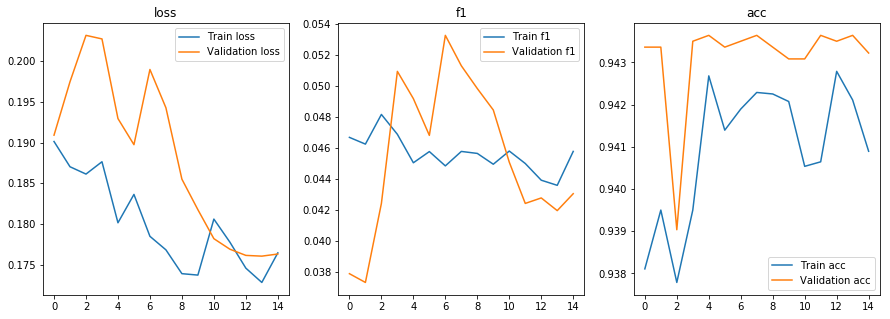

In [26]:
show_history(history)